# GEOG 5160 6160 Lab 08

## Data processing

Let's start by by importing the modules we'll need for the class, then we'll go get the data

In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)
## Set random seed for reproducibility
np.random.seed(1234)

### Pinus edulis data

Now, let's read in the known locations of *Pinus edulis* trees from the file *Pinus_edulis.csv*, and a set of pseudo-absences from the file *absence.csv*

In [2]:
presence = pd.read_csv("../datafiles/Pinus_edulis.csv")
presence.describe()

,gbifid,latitude,longitude
count,2.990000e+02,299.000000,299.000000
mean,1.572063e+09,36.275753,-108.587322
std,3.916628e+08,2.061340,3.096906
min,5.662771e+07,31.707778,-115.585586
25%,1.453172e+09,35.161349,-111.825712
50%,1.677271e+09,36.066280,-108.347447
75%,1.847535e+09,37.671059,-105.833923
max,1.899817e+09,40.894330,-102.947806


In [3]:
absence = pd.read_csv("../datafiles/absence.csv")
absence.describe()

,longitude,latitude
count,299.000000,299.000000
mean,-109.292623,36.644873
std,3.969942,3.079582
min,-117.353659,30.033673
25%,-112.247613,34.226212
50%,-109.372950,36.786324
75%,-106.106656,39.117459
max,-100.861639,42.491026


We'll need to append these two datasets to have both presence and absence in the same DataFrame. 

- Append the coordinates
- Create a binary Series where 0 = absence and 1 = presence
- Convert to a Pandas DataFrame

In [4]:
lon = presence.longitude.append(absence.longitude).values
lat = presence.latitude.append(absence.latitude).values

pa = pd.Series([1, 0]).repeat(299).values

frame = { 'longitude': lon, 
         'latitude': lat,
         'pa': pa
        } 
pe = pd.DataFrame(frame)
pe.describe()

/var/folders/ws/m03sh3xd4ns621mckfrht3r0000_08/T/ipykernel_28607/1927474588.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lon = presence.longitude.append(absence.longitude).values
/var/folders/ws/m03sh3xd4ns621mckfrht3r0000_08/T/ipykernel_28607/1927474588.py:2: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  lat = presence.latitude.append(absence.latitude).values


,longitude,latitude,pa
count,598.000000,598.000000,598.000000
mean,-108.939973,36.460313,0.500000
std,3.574768,2.624708,0.500419
min,-117.353659,30.033673,0.000000
25%,-111.962634,34.874440,0.000000
50%,-108.952680,36.375596,0.500000
75%,-105.889698,38.455610,1.000000
max,-100.861639,42.491026,1.000000


#### Environmental data

There are a large number of available data sources for environmental data that can be used in species distribution models. We'll take data from the [Worldclim project][wcID] (Hijmans et al. 2005), a collection of standardized climate data at a variety of spatial resolutions. The data contains monthly averages of temperature and precipitation and a set of bioclimatic variables, which represent aggregate climate variables assumed to be linked to species distributions. I've already downloaded the bioclimatic variables for you and clipped them to the region you're going to work in. These are available in two NetCDF files containing modern (*current_env.nc*) and future (*future_env.nc*) climates for the study area. 

NetCDF is a standard format for large, multidimensional gridded dataset, and is commonly used to store climate data. Python has several libraries that will read these files. We'll use `xarray` here, as it comes with some simple functions to extract values and plot the data that work well with these data. The output of the `info` method gives you an overview of the dataset, including the dimensions, coordinates and the variables. Each z-level in this file stores one of the 19 bioclimate variables (the description of each of these is given in the appendix). 

In [5]:
import xarray as xr
curr_env = xr.open_dataset('../datafiles/current_env.nc')
curr_env.info
#curr_env['variable'].sel(lon=-107, lat=40)

<bound method Dataset.info of <xarray.Dataset>
Dimensions:    (longitude: 720, latitude: 480, z: 19)
Coordinates:
  * longitude  (longitude) float64 -130.0 -129.9 -129.9 ... -100.1 -100.1 -100.0
  * latitude   (latitude) float64 49.98 49.94 49.9 49.85 ... 30.1 30.06 30.02
  * z          (z) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Data variables:
    crs        int32 ...
    BIO        (z, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.4
    created_by:   R, packages ncdf4 and raster (version 3.4-5)
    date:         2021-03-10 13:49:36>

`xarray` introduces two new data objects to Python, a DataArray (which contain the variables we are interested in) and a DataSet, which is a collection of DataArrays. The `current_env` DataSet contains two DataArrays (`crs` and `BIO`). The second of these contains the bioclimate variables that we want to work with. 

In [6]:
curr_env.BIO

<xarray.DataArray 'BIO' (z: 19, latitude: 480, longitude: 720)>
[6566400 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float64 -130.0 -129.9 -129.9 ... -100.1 -100.1 -100.0
  * latitude   (latitude) float64 49.98 49.94 49.9 49.85 ... 30.1 30.06 30.02
  * z          (z) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Attributes:
    grid_mapping:  crs
    proj4:         +proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0
    min:           [ -7.1   5.6   2.4 165.9   6.  -24.1  11.8 -13.5 -15.3   0...
    max:           [  23.9   21.3    6.5 1299.2   45.6   10.    50.9   33.2  ...

You can plot any individual layer using the `plot()` method. Note the indexing used to identify the layer to be shown (`BIO[0]` = the first layer):

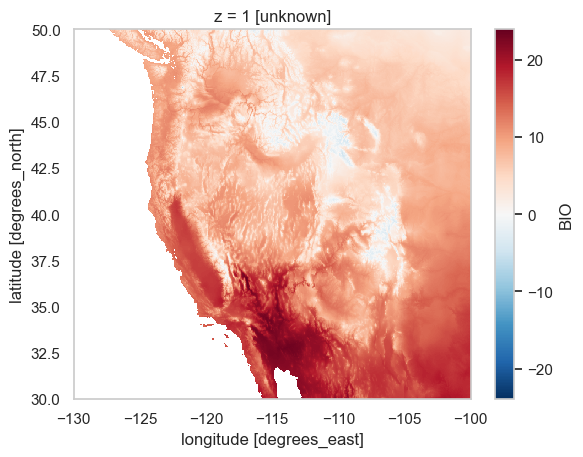

In [7]:
curr_env.BIO[0].plot()

As the region we are using for our study area includes part of the Pacific Ocean, we'll create a land/sea mask. This will be used later to mask out any predictions over the ocean.  This is done quite simple by creating an array with 2's over the ocean (the NaN values in the data) and a second with 1's over the land. Then these are combined into the final mask.

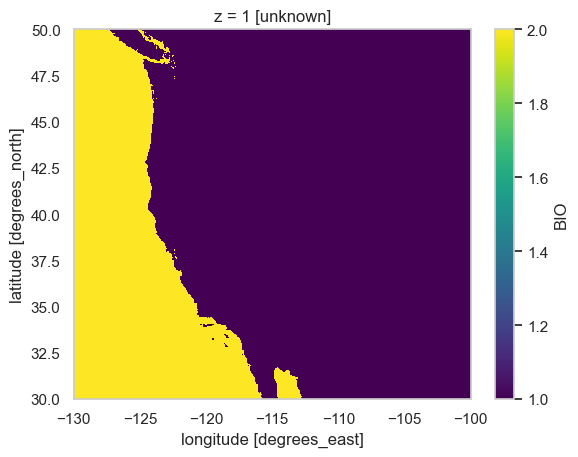

In [8]:
mask_ocean = 2 * np.ones((curr_env.dims['latitude'], 
                          curr_env.dims['longitude'])) * np.isnan(curr_env.BIO.isel(z=0))  
mask_land = 1 * np.ones((curr_env.dims['latitude'], 
                         curr_env.dims['longitude'])) * np.isfinite(curr_env.BIO.isel(z=0))  
mask_array = mask_ocean + mask_land
mask_array.plot()

We also have the same data for the future (2080 under a high emissions climate scenario), so let's load that as well. Once we have built our model, we can then predict the distribution of Pinus edulis under this changed climate. 

In [9]:
future_env = xr.open_dataset('../datafiles/future_env.nc')
future_env.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:    (longitude: 720, latitude: 480, z: 19)
Coordinates:
  * longitude  (longitude) float64 -130.0 -129.9 -129.9 ... -100.1 -100.1 -100.0
  * latitude   (latitude) float64 49.98 49.94 49.9 49.85 ... 30.1 30.06 30.02
  * z          (z) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Data variables:
    crs        int32 ...
    BIO        (z, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.4
    created_by:   R, packages ncdf4 and raster (version 3.4-5)
    date:         2021-03-10 13:48:41>

Now we have the presence and absence points, we need to extract the environmental values for these points (these will be a features for machine learning). To do this we use the following steps:

- Create sets of coordinates for the presence/absence data in `xarray` format
- Use the `sel()` method to extract the associated climate values from the environmental grids for these coordinates
- Convert the extracted data to a Pandas DataFrame
- Concatenate the presence/absence data frame with the environmental variables

In [10]:
lons = xr.DataArray(pe.longitude, dims='x')
lats = xr.DataArray(pe.latitude, dims='x')

In [11]:
data = curr_env.BIO.sel(latitude = lats, longitude = lons, method = 'nearest')
data.values

array([[  8. ,   6.4,   5.8, ...,  11.8,  16. ,  11.8],
       [ 16.6,  16.7,  16.2, ...,  17.7,  17.3,  16.8],
       [  4.2,   4.2,   4.2, ...,   4.5,   4.5,   4.2],
       ...,
       [ 34. ,  38. ,  43. , ...,  41. ,  31. ,  41. ],
       [194. , 204. , 214. , ..., 142. , 155. ,  49. ],
       [ 34. ,  38. ,  43. , ...,  47. ,  33. ,  60. ]], dtype=float32)

In [12]:
var_names = ["bio"+str(i+1) for i in range(19)]
x = pd.DataFrame(data.values.transpose(),
                columns = var_names)

In [13]:
pe = pd.concat([pe, x], axis=1)
pe

,longitude,latitude,pa,bio1,bio2,bio3,bio4,bio5,bio6,bio7,...,bio10,bio11,bio12,bio13,bio14,bio15,bio16,bio17,bio18,bio19
0,-104.896667,38.866005,1,8.0,16.600000,4.2,789.000000,28.700001,-10.5,39.200001,...,18.500000,-1.7,427.0,73.0,9.0,60.0,194.0,34.0,194.0,34.0
1,-104.883196,38.875486,1,6.4,16.700001,4.2,778.099976,27.000000,-12.1,39.099998,...,16.700001,-3.2,452.0,76.0,10.0,59.0,204.0,38.0,204.0,38.0
2,-104.839340,38.722775,1,5.8,16.200001,4.2,778.000000,26.100000,-12.4,38.500000,...,16.100000,-3.8,474.0,81.0,11.0,58.0,214.0,43.0,214.0,43.0
3,-104.897199,38.864713,1,8.0,16.600000,4.2,789.000000,28.700001,-10.5,39.200001,...,18.500000,-1.7,427.0,73.0,9.0,60.0,194.0,34.0,194.0,34.0
4,-104.855046,38.908459,1,8.2,16.400000,4.1,792.900024,28.900000,-10.2,39.099998,...,18.799999,-1.5,426.0,72.0,9.0,60.0,194.0,34.0,194.0,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,-102.534971,34.525225,0,13.4,16.700001,4.2,800.900024,32.500000,-6.4,38.900002,...,23.600000,3.0,444.0,74.0,11.0,61.0,203.0,37.0,203.0,37.0
594,-109.901510,39.715135,0,7.9,15.700000,3.4,985.799988,31.299999,-13.6,44.900002,...,20.400000,-5.2,242.0,26.0,14.0,20.0,78.0,45.0,66.0,45.0
595,-106.530940,34.174115,0,11.8,17.700001,4.5,762.299988,31.600000,-6.9,38.500000,...,21.700001,2.1,321.0,64.0,13.0,64.0,164.0,41.0,142.0,47.0
596,-103.782630,32.707550,0,16.0,17.299999,4.5,757.799988,34.500000,-3.6,38.099998,...,25.600000,6.1,358.0,64.0,9.0,66.0,174.0,31.0,155.0,33.0


Before moving on, we'll convert this new DataFrame to a GeoPandas dataframe, so we can make some quick maps of the presence/absence values and one of the associated environmental variables (`bio7`). 

In [14]:
import geopandas as gpd
pe_gpd = gpd.GeoDataFrame(pe, 
                          geometry=gpd.points_from_xy(pe.longitude, pe.latitude), 
                               crs=4326)

<Axes: >

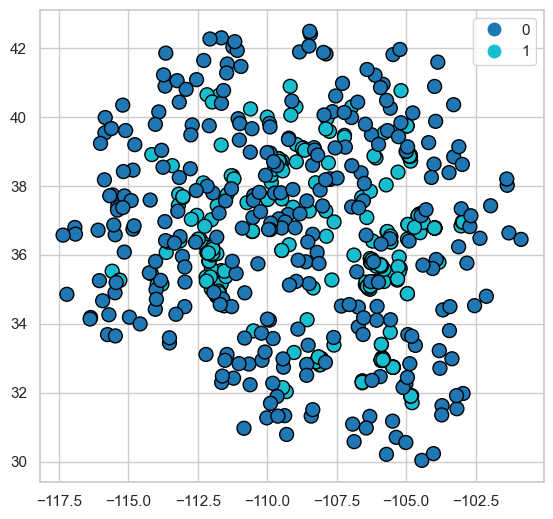

In [15]:
pe_gpd.plot(column="pa", figsize = (6.5, 6.5), categorical=True, 
            markersize = 100, legend=True, edgecolor="black")

<Axes: >

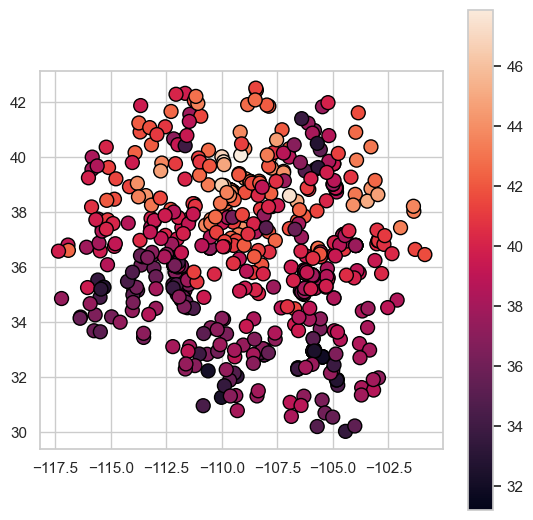

In [16]:
pe_gpd.plot(column="bio7", figsize = (6.5, 6.5), 
            markersize = 100, legend=True, edgecolor="black")

## Tree methods

### Classification and regression trees

Classification and Regression Trees (CART) is a non-linear, non-parametric modeling approach that can be used with a wide variety of data. Regression trees are used with continuous outcome data, and classification trees with binary or categorical data, but the interface for these is the same in scikit-learn.

We'll build a classification model for the *Pinus edulis* data set. First, let's set up the training and testing set using all 19 of the bioclimatic variables:

In [17]:
var_names = ["bio"+str(i+1) for i in range(19)]

X = pe[var_names]
y = pe['pa']

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size = 0.8)

In [19]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(478, 19)
(478,)
(120, 19)
(120,)


No prizes for guessing that the scikit-learn function for a classification decision tree is called `DecisionTreeClassifier()`. Let's initialize one of these, and train it on our dataset

In [20]:
from sklearn import tree
pe_tree = tree.DecisionTreeClassifier()
pe_tree = pe_tree.fit(X_train, y_train)

And plot the resulting tree:

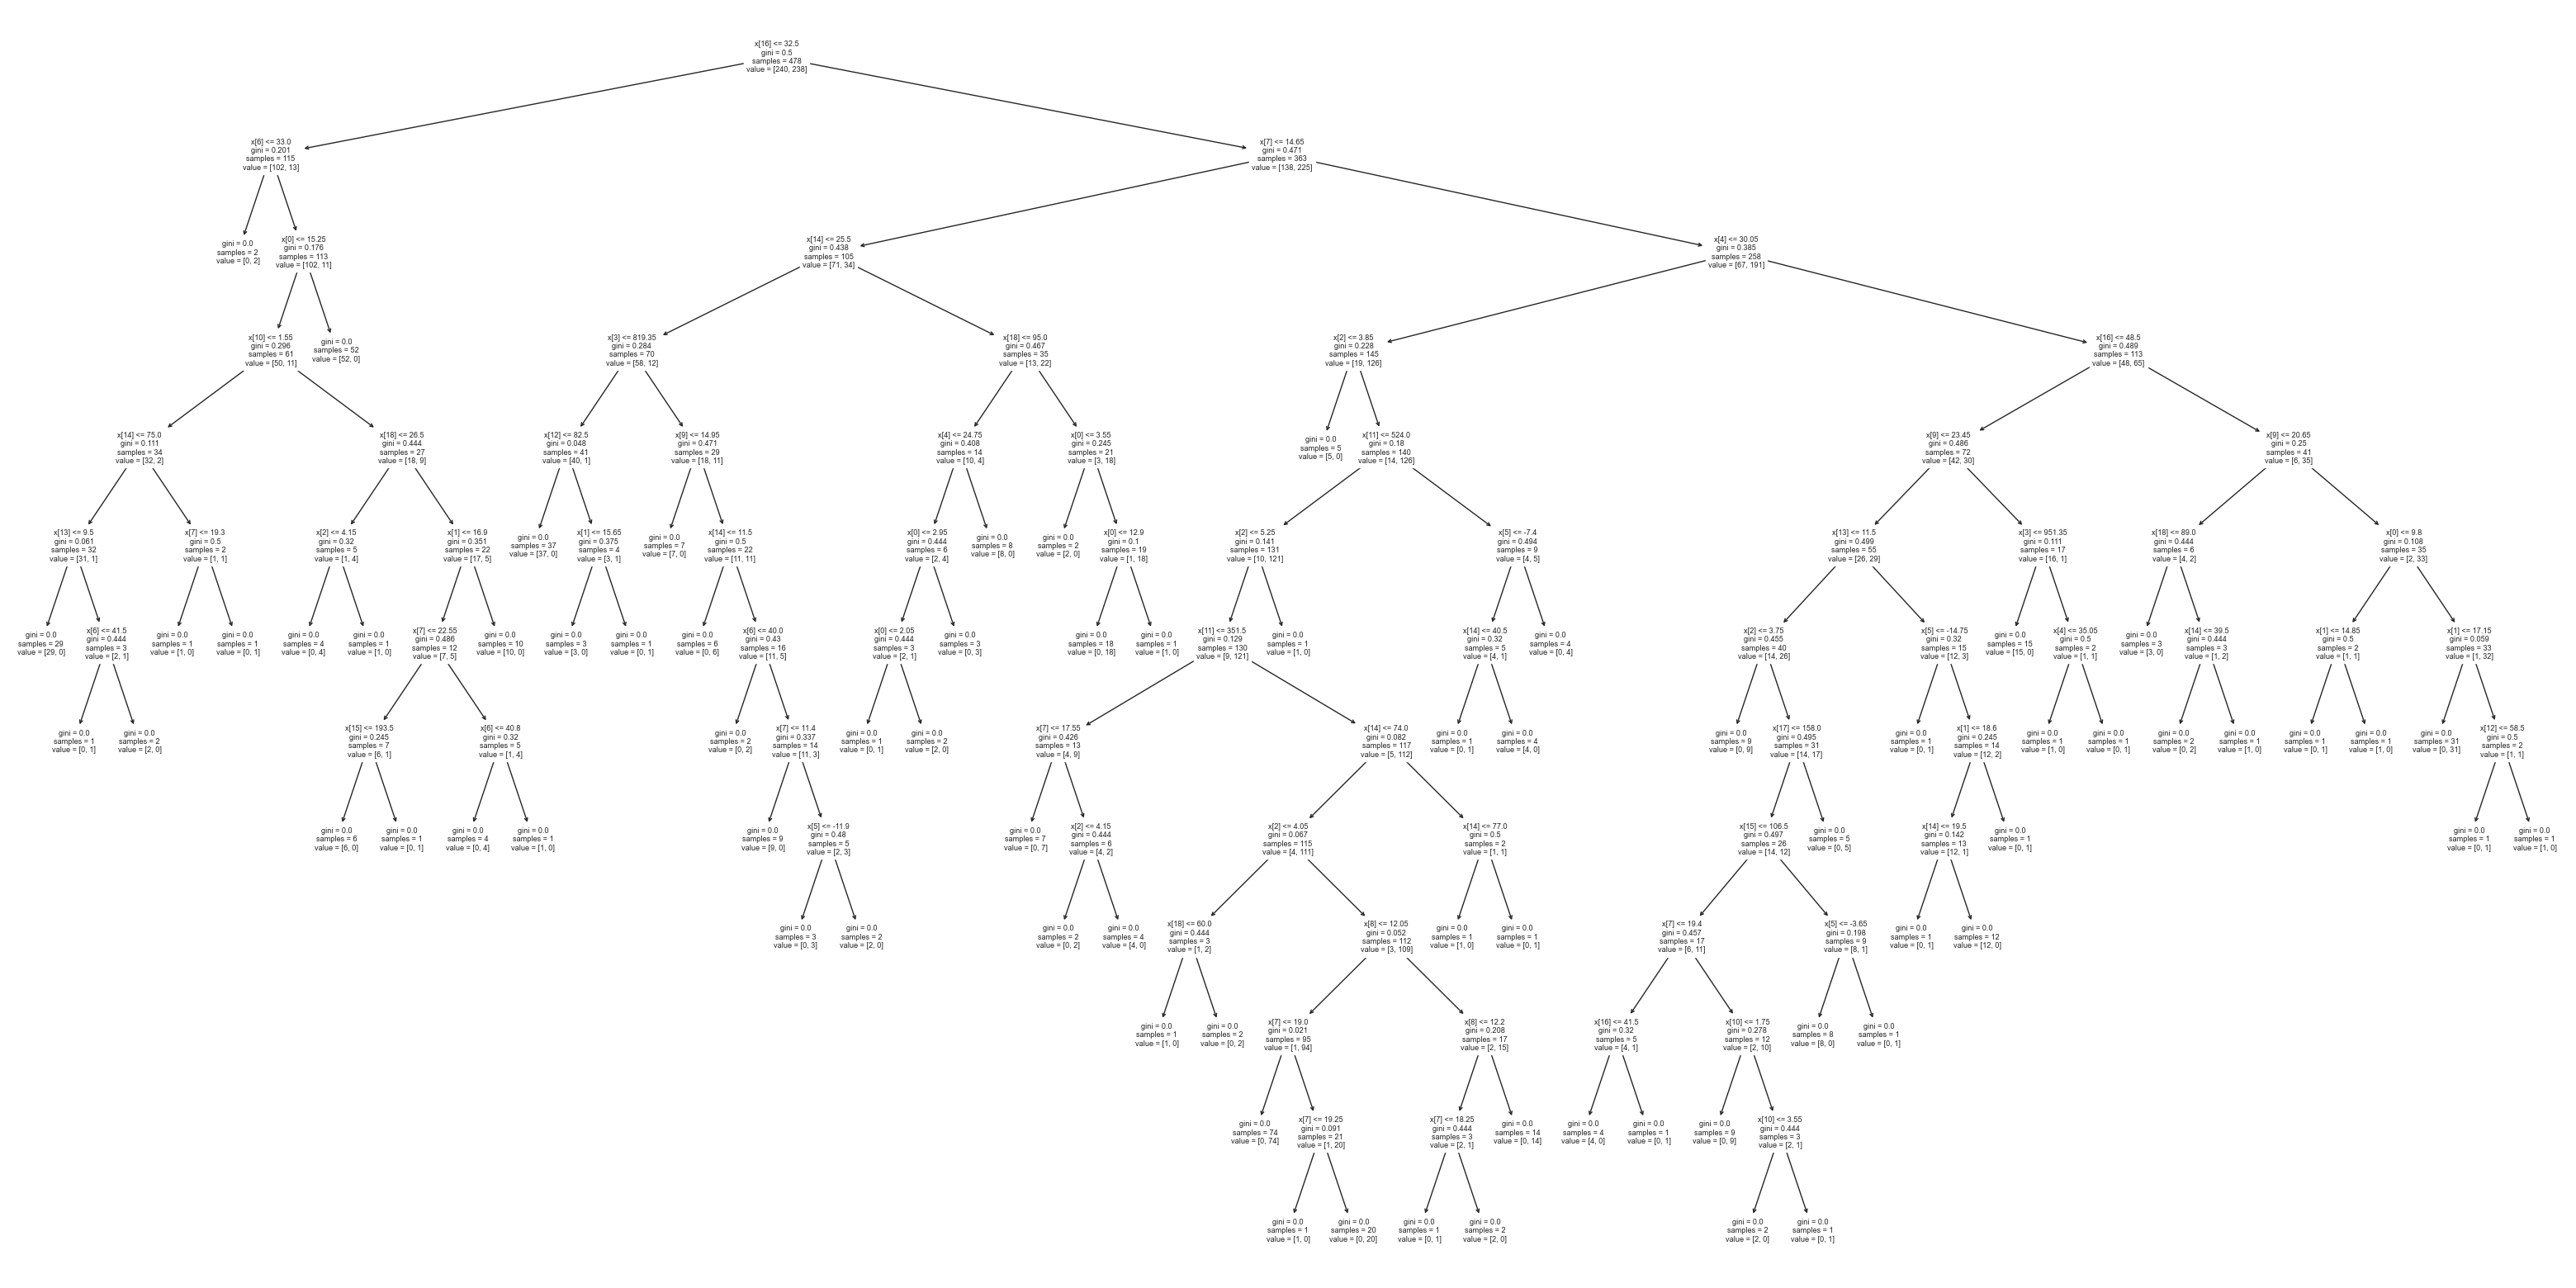

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40,20)) 
tree.plot_tree(pe_tree)
plt.show()

Again, the default settings results in a very overfit tree. To illustrate this, let's calculate the AUC on the testing set:

In [22]:
from sklearn import metrics
y_test_pred = pe_tree.predict_proba(X_test)
metrics.roc_auc_score(y_test, y_test_pred[:,1])

0.7827174215059739

### Tuning

Let's try to improve on this model by tuning it to find the best set of hyperparameters to limit overfitting. You can get the list of available hyperparameters for any scikit-learn model using `get_params()`

In [23]:
tree.DecisionTreeClassifier().get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

There are several here that we could try to tune, but we'll focus on two that are important in limiting tree size:

- `max_depth`: the maximum number of splits along any branch of the tree
- `min_samples_leaf`: the minimum number of samples in a child node for it to be considered in the splitting procedure

We'll use a scikit-learn function to help with the tuning called `GridSearchCV()`. As the name might imply, this will carry out a cross-validated search among a set of hyperparameter values to find the best value. Practically, this takes the dataset, splits it into training and testing, builds several models with different parameter values and predicts for the test set. The best values are then saved and returned. 

After importing the function, we need to define the parameter space that will be searched. This is set up as a Python dictionary, with the name of the hyperparameter as the key, and the value or set of values to be tested. Any parameters that are not specified will be held at their default values. 

In [24]:
from sklearn.model_selection import GridSearchCV
tree_param = {'max_depth':[4,5,6,7,8,9,10],
             'min_samples_leaf':[5,6,7,8,9,10]}

Having done this, we set up the cross-validation strategy using `GridSearchCV()`. We need to specify:

- The algorithm to be tuned
- The parameter space
- The performance metric to be used to select the parameter values
- The cross-validation strategy. Here we are using a simple 5-fold cross-validation, but it is possible to replace this with more complex strategies

In [25]:
pe_tree_tuned = GridSearchCV(tree.DecisionTreeClassifier(), tree_param, 
                             scoring='roc_auc', cv=5)

Now we use the standard scikit-learn `fit()` method to run the tuning

In [26]:
pe_tree_tuned.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': [5, 6, 7, 8, 9, 10]},
             scoring='roc_auc')

The full set of results are held in `pe_tree_tuned.cv_results_`, but we'll just show here the range of AUC scores found during tuning. These vary a little (from just under 0.8 to about 0.83). Tuning has a relatively small impact on decision trees, so this small range is not too surprising.

In [27]:
print(pe_tree_tuned.cv_results_['mean_test_score'])

[0.80890034 0.81968547 0.82104019 0.81800199 0.83009659 0.82848792
 0.81169936 0.80464225 0.81370327 0.82119625 0.8278415  0.82501108
 0.79486093 0.81073341 0.80621214 0.80772015 0.80965204 0.82703716
 0.7918726  0.79792775 0.79735243 0.80138797 0.80814218 0.80591755
 0.78516179 0.77899675 0.7963043  0.8062029  0.80554632 0.80950428
 0.78306553 0.77884068 0.79986794 0.7965601  0.79807366 0.80690381
 0.76961806 0.78133958 0.79650746 0.80244164 0.81124224 0.81045361]


We can also extract the `best_estimator`, i.e. the best tree that was built to see the parameters that were used, and the score it obtained. 

In [28]:
print(pe_tree_tuned.best_estimator_)
print(pe_tree_tuned.best_score_)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=9)
0.8300965942671394


In [29]:
print('Best max_depth:', pe_tree_tuned.best_estimator_.get_params()['max_depth'])
print('Best min_samples_leaf:', pe_tree_tuned.best_estimator_.get_params()['min_samples_leaf'])

Best max_depth: 4
Best min_samples_leaf: 9


Finally, let's re-predict for our test set and see if we've improved on the original default model

In [30]:
y_test_pred = pe_tree_tuned.predict_proba(X_test)
metrics.roc_auc_score(y_test, y_test_pred[:,1])

0.8530147263128647

## Random forest

Next, we'll build a random forest for the Pinus data. scikit-learn's random forest functions are found in the `ensemble` sub-module. Let's import this and then set up, train and test a random forest classifier. 

In [31]:
from sklearn import ensemble

In [32]:
pe_rf = ensemble.RandomForestClassifier()
pe_rf.fit(X_train, y_train)
y_test_pred = pe_rf.predict_proba(X_test)
metrics.roc_auc_score(y_test, y_test_pred[:,1])

0.9156710197277019

Even with its default settings, this model shows a decent improvement over the decision tree. We'll now try to tune it. First, look at the available parameters:

In [33]:
ensemble.RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Again, there are several hyperparameters that we could tune. We'll focus again on two: `n_estimators` (the number of trees in the forest) and `max_features` (the number of randomly selected features used for each split)

In [34]:
rf_param = {'n_estimators':[100, 200, 300, 400, 500],
             'max_features':[2,4,6]}

We now run our tuning grid search using these parameters and a random forest:

In [35]:
pe_rf_tuned = GridSearchCV(ensemble.RandomForestClassifier(), rf_param, 
                             scoring='roc_auc', cv=5)
pe_rf_tuned.fit(X_train, y_train)
print(pe_rf_tuned.cv_results_['mean_test_score'])

[0.89544548 0.89790466 0.89801178 0.89547318 0.90015514 0.89434194
 0.89917073 0.89905714 0.89817431 0.89670324 0.89298445 0.89608821
 0.89561355 0.89458296 0.89440566]


And look at the best fitting model:

In [36]:
print(pe_rf_tuned.best_estimator_)
print(pe_rf_tuned.best_score_)

RandomForestClassifier(max_features=2, n_estimators=500)
0.9001551418439717


Now let's see if tuning the model has improved over the default (I got a very slight improvement, but your mileage may vary):

In [37]:
y_test_pred = pe_rf_tuned.predict_proba(X_test)
metrics.roc_auc_score(y_test, y_test_pred[:,1])

0.9217838288413447

#### Variable importance

Next we'll plot the permutation-based variable importance for this model. As a reminder, variable importance is a measure of how much worse a model becomes when we scramble the values of one of the features. The model is used to predict the outcome for some test data (here the out-of-bag samples) twice: once with the original values of the feature and once with randomly shuffled values. If there is a large difference in the skill of the model, this feature is important in controlling the outcome. 

As the result of the grid-based tuning includes the best estimator, we'll use this to get the variable importance values as follows:

In [38]:
pe_rf_tuned.best_estimator_.feature_importances_

array([0.06914366, 0.037916  , 0.03610041, 0.04975633, 0.06504958,
       0.05275026, 0.04981274, 0.06658155, 0.04306546, 0.06573343,
       0.06386524, 0.05514812, 0.03950581, 0.04119386, 0.05015202,
       0.03812184, 0.07553368, 0.05144355, 0.04912648])

As this is a just an array, it is a little difficult to parse out any differences. Instead, we'll sort them and print them together with the feature names:

In [39]:
importances = pe_rf_tuned.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], var_names[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature 16 bio17 (0.075534)
2. feature 0 bio1 (0.069144)
3. feature 7 bio8 (0.066582)
4. feature 9 bio10 (0.065733)
5. feature 4 bio5 (0.065050)
6. feature 10 bio11 (0.063865)
7. feature 11 bio12 (0.055148)
8. feature 5 bio6 (0.052750)
9. feature 17 bio18 (0.051444)
10. feature 14 bio15 (0.050152)
11. feature 6 bio7 (0.049813)
12. feature 3 bio4 (0.049756)
13. feature 18 bio19 (0.049126)
14. feature 8 bio9 (0.043065)
15. feature 13 bio14 (0.041194)
16. feature 12 bio13 (0.039506)
17. feature 15 bio16 (0.038122)
18. feature 1 bio2 (0.037916)
19. feature 2 bio3 (0.036100)


And we can also plot the values as a bar plot:

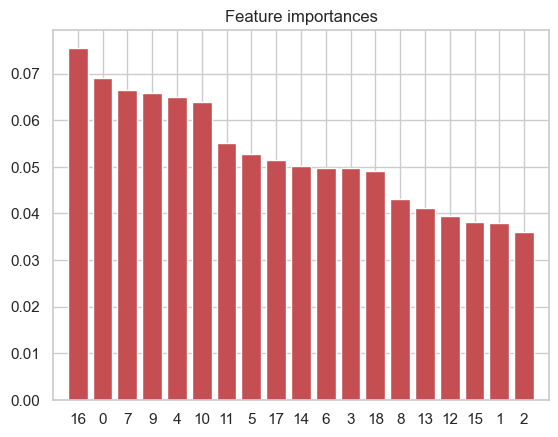

In [40]:
# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

We can look at the form of the relationship between the occurrence of the pine and this feature (and any other one) using a partial dependency plot. This shows changes in the outcome across the range of some feature (with all other features held constant). Here, we'll use the `plot_partial_dependence()` function from the the `inspection` submoduleto produce the plot. As arguments, this requires the model, the DataFrame or array used to build the model, and the feature that you want to show. This will take an array of feature indices, allowing you to plot several dependency plots together.


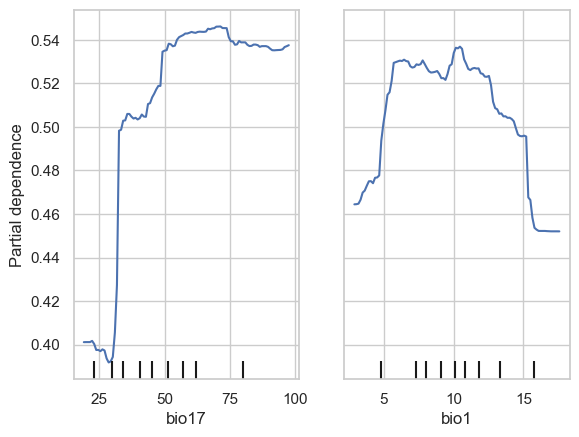

In [41]:
from sklearn.inspection import PartialDependenceDisplay
#plot_partial_dependence(pe_rf_tuned.best_estimator_, X, [16,0]) 
PartialDependenceDisplay.from_estimator(pe_rf_tuned.best_estimator_, X, [16,0])

The two features here are `bio17` (precipitation of driest quarter) and `bio1` (mean annual temperature. The first of these shows a clear threshold effect, with an abrupt drop in suitability as this drops below about 30. The second show more of an optimum between values of about 6 and 10 degrees.

### XGBoost

We will now build a boosted regression tree model for the Pinus data. In contrast to random forests that build a set of individual weak trees, boosted regression trees (BRTs) start with a single weak tree and iteratively improve on this. This is done by targeting the residuals from the previous set of models and trying to model that in the next tree. While this can make these methods very powerful, it is easy for them to overfit the data, and hyperparameter tuning becomes very important here. 

While scikit-learn has its own implementation of boosted regression, an alternative is through the xgboost library. This has a number of advantages with memory management and parallelization which can greatly speed up fitting these models, and we'll use this. It has a very similar interface to scikit-learn, so we can just reuse the data and tuning approaches from previous models. As before, we'll start by simply running it with the default settings:

In [42]:
from xgboost import XGBClassifier
pe_xgb = XGBClassifier()
pe_xgb.fit(X_train, y_train)
y_test_pred = pe_xgb.predict_proba(X_test)
metrics.roc_auc_score(y_test, y_test_pred[:,1])

0.9124756876910253

Now we'll try to tune it. First, get a list of available parameters

In [43]:
XGBClassifier().get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

Well, there's a lot. A thorough search strategy would probably include some of the following parameters:

In [44]:
# Define our search space for grid search
xgb_param = {
            'max_depth': [3, 4, 5],
            'learning_rate': [0.1, 0.2, 0.3],
            'n_estimators': [50, 100, 150],
            'gamma': [0, 0.1, 0.2],
            'min_child_weight': [0, 0.5, 1],
            'max_delta_step': [0],
            'subsample': [0.7, 0.8, 0.9, 1],
            'colsample_bytree': [0.6, 0.8, 1],
            'colsample_bylevel': [1],
            'reg_alpha': [0, 1e-2, 1, 1e1],
            'reg_lambda': [0, 1e-2, 1, 1e1],
            'base_score': [0.5]
            }

In the interest of keeping this relatively fast, we'll just test the following parameters, each with a fairly coarse grid. In practice, you'd want to do this more exhaustively. 

- `max_depth`: the number of splits in each tree
- `learning_rate`: the contribution of each tree to the overall model
- `n_estimators`: the total number of trees built

We also set the parameter `subsample` to 0.5 to only use a random selection of observations in building each tree. As this is a constant, it won't be varied during the grid search. Once this is setup, we'll run the usual cross-validated grid search. You might see a few warnings appear, you can safely ignore these.

In [45]:
xgb_param = {
    'max_depth': [1, 3, 5],
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [100, 300, 500],
    'subsample': [0.5], 
    'eval_metric': ['logloss']
}

pe_xgb_tuned = GridSearchCV(XGBClassifier(), xgb_param, 
                             scoring='roc_auc', cv=5, verbose = 0)
pe_xgb_tuned.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'eval_metric': ['logloss'],
                         'learning_rate': [0.1, 0.2, 0.3],
                         'max_depth': [1, 3, 5],
                         'n_estimators': [100, 300, 500], 'subsample': [0.5]},
             scoring='roc_auc')

In [46]:
print(pe_xgb_tuned.best_estimator_)
print(pe_xgb_tuned.best_score_)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_bin=256,
              max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
              max_depth=5, max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=300, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0, ...)
0.88785091607565


Now run the model to predict for our test samples. This does give a small but notable increase over the un-tuned model. 

In [47]:
y_test_pred = pe_xgb_tuned.predict_proba(X_test)
metrics.roc_auc_score(y_test, y_test_pred[:,1])

0.9071964434565156

We can again extract the variable importance scores from the tuned model, which again shows `bio17` as being the most importance feature. 

In [48]:
importances = pe_xgb_tuned.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d %s (%f)" % (f + 1, indices[f], var_names[indices[f]], importances[indices[f]]))

Feature ranking:
1. feature 16 bio17 (0.092542)
2. feature 7 bio8 (0.066138)
3. feature 9 bio10 (0.065923)
4. feature 13 bio14 (0.060826)
5. feature 0 bio1 (0.058309)
6. feature 10 bio11 (0.056133)
7. feature 17 bio18 (0.052959)
8. feature 14 bio15 (0.051278)
9. feature 4 bio5 (0.050562)
10. feature 1 bio2 (0.049651)
11. feature 2 bio3 (0.049118)
12. feature 6 bio7 (0.047951)
13. feature 12 bio13 (0.047610)
14. feature 5 bio6 (0.047320)
15. feature 8 bio9 (0.044633)
16. feature 3 bio4 (0.044079)
17. feature 11 bio12 (0.043720)
18. feature 18 bio19 (0.041175)
19. feature 15 bio16 (0.030074)


## Predictions

Now we tested and tuned our models, we can use them for prediction. For species distribution models, we generally want to predict the suitability for our species using a gridded dataset of the environmental variables used to build the model. We loaded this earlier in the lab as `curr_env`. As a reminder, this is an xarray `DataSet`. 


In [49]:
curr_env.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:    (longitude: 720, latitude: 480, z: 19)
Coordinates:
  * longitude  (longitude) float64 -130.0 -129.9 -129.9 ... -100.1 -100.1 -100.0
  * latitude   (latitude) float64 49.98 49.94 49.9 49.85 ... 30.1 30.06 30.02
  * z          (z) int32 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
Data variables:
    crs        int32 ...
    BIO        (z, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.4
    created_by:   R, packages ncdf4 and raster (version 3.4-5)
    date:         2021-03-10 13:49:36>

Unfortunately, we can't use this directly for predictions. We'll need to convert it to a Pandas DataFrame. This requires a couple of steps. First, we use the `stack()` method to collapse the multiple levels into a 2D array, where the rows represent the variables and the columns represent individual grid locations:

In [50]:
bio_stack = curr_env.BIO.stack(dim = ['latitude', 'longitude'])
print(bio_stack.values)
print(bio_stack.shape)
print(bio_stack.dim.values)

[[  nan   nan   nan ...  18.2  18.2  17.9]
 [  nan   nan   nan ...  14.3  14.4  14.4]
 [  nan   nan   nan ...   4.2   4.2   4.2]
 ...
 [  nan   nan   nan ...  86.   87.   89. ]
 [  nan   nan   nan ... 204.  205.  208. ]
 [  nan   nan   nan ...  87.   87.   89. ]]
(19, 345600)
[(49.979166666666664, -129.97916666666666) (49.979166666666664, -129.9375)
 (49.979166666666664, -129.89583333333334) ...
 (30.020833333333336, -100.10416666666667) (30.020833333333336, -100.0625)
 (30.020833333333336, -100.02083333333334)]


Now we create a DataFrame with the environmental variables. This needs to be transposed to have the same format as the DataFrame used in training the model

In [51]:
curr_env_df = pd.DataFrame(bio_stack.values.transpose(),
                columns = var_names)
curr_env_df

,bio1,bio2,bio3,bio4,bio5,bio6,bio7,bio8,bio9,bio10,bio11,bio12,bio13,bio14,bio15,bio16,bio17,bio18,bio19
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
345595,18.100000,14.1,4.3,659.000000,33.500000,0.8,32.700001,23.000000,10.2,26.000000,9.1,625.0,81.0,22.0,39.0,216.0,82.0,201.0,84.0
345596,18.200001,14.2,4.2,668.299988,33.700001,0.6,33.099998,23.100000,10.1,26.200001,9.0,633.0,82.0,23.0,39.0,218.0,84.0,202.0,85.0
345597,18.200001,14.3,4.2,673.599976,33.799999,0.4,33.400002,23.100000,10.0,26.299999,9.0,638.0,82.0,24.0,39.0,220.0,86.0,204.0,87.0
345598,18.200001,14.4,4.2,680.200012,33.900002,0.3,33.599998,23.100000,10.0,26.400000,8.9,644.0,83.0,24.0,39.0,222.0,87.0,205.0,87.0


We can now use this to predict suitability. The only problem here is that there are number of rows that have missing values (NaNs) representing ocean grid cells. If we try to use these to predict, the method will fail, so we need a way to ignore them. We could simply drop them from the DataFrame, but this makes it difficult to map out the predictions, as these no longer line up with the coordinates. Instead, we'll set all missing values to 0 with the `fillna()` method. This means that the model will predict for these grid cells, but we can use the mask we created when visualizing the results. 

We'll go ahead and predict suitability using the tuned random forest model (feel free to swap this out for the decision tree of xgboost model):

In [52]:
x = pe_rf_tuned.predict_proba(curr_env_df.fillna(0))
x.shape

(345600, 2)

Once this is done, we can convert it back to an xarray using the values (`x`) and the grid coordinates (which are extracted from the original `curr_env` object):

In [53]:
curr_pred = xr.DataArray(x[:,1].reshape(480,720), 
                         coords=[curr_env.coords['latitude'], 
                                 curr_env.coords['longitude']])

And now we can plot out the results:

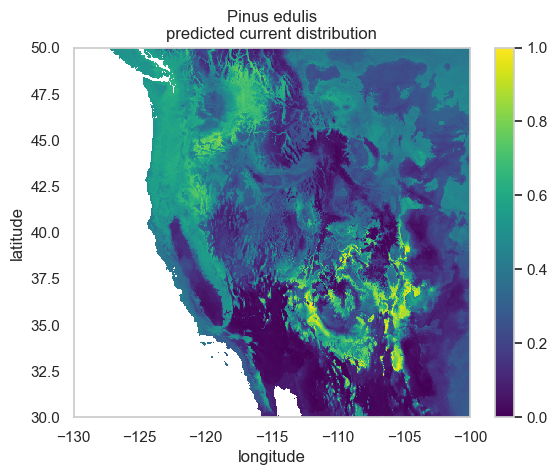

In [54]:
curr_pred.where(mask_array == 1).plot()
plt.title("Pinus edulis\npredicted current distribution")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()

This shows that model captures the current distribution well, but also predicts a large area of suitability in the north-west. We can also plot the predicted presence/absence as a binary outcome. To do this, we first need to get the optimal threshold for discriminating between absence (0) and presence (1):

In [55]:
y_test_pred = pe_rf_tuned.predict_proba(X_test)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred[:,1])
threshold_rf = thresholds[np.argmax(tpr - fpr)]
print(threshold_rf)

0.594


And now we can plot this:

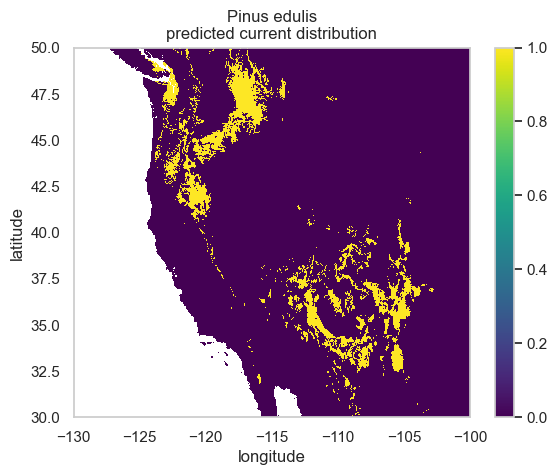

In [56]:
curr_pa = curr_pred > threshold_rf

curr_pa.where(mask_array == 1).plot()
plt.title("Pinus edulis\npredicted current distribution")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()

### Future climate

The previous maps are based on current (or at least end of last century) estimates of climate. We can equally predict for other time periods when we have data available. Earlier in the lab we read in climate data for the end of the century under a high emissions scenario (RCP8.5). We can go through the same steps to produce a map showing projected suitability for this species

In [57]:
bio_stack = future_env.BIO.stack(dim = ['latitude', 'longitude'])
future_env_df = pd.DataFrame(bio_stack.values.transpose(),
                columns = var_names)
future_crds = pd.DataFrame(bio_stack.dim.values)

In [58]:
x = pe_rf_tuned.predict_proba(future_env_df.fillna(0))
future_pred = xr.DataArray(x[:,1].reshape(480,720), 
                         coords=[future_env.coords['latitude'], 
                                 future_env.coords['longitude']])

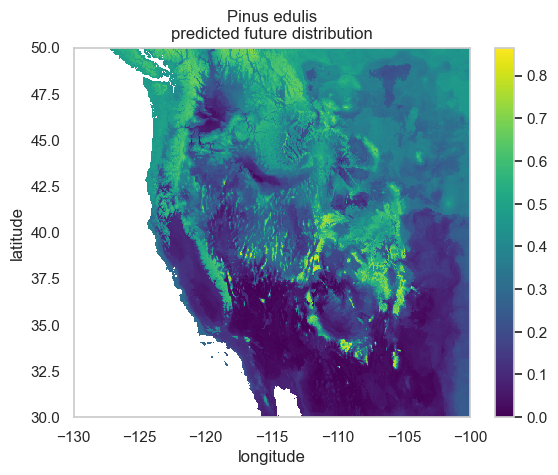

In [59]:
future_pred.where(mask_array == 1).plot()
plt.title("Pinus edulis\npredicted future distribution")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()

And again, we can use the threshold to identify areas of suitability. 

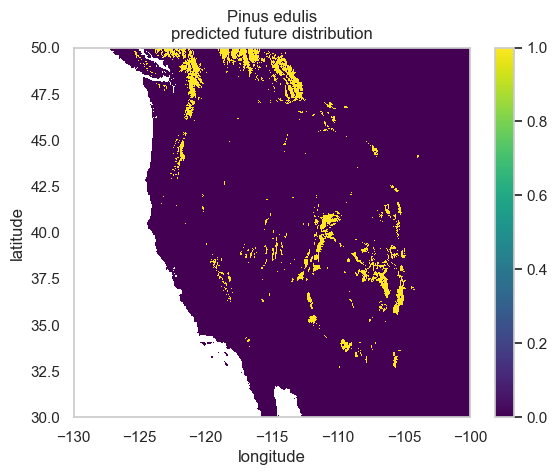

In [60]:
future_pa = future_pred > threshold_rf

future_pa.where(mask_array == 1).plot()
plt.title("Pinus edulis\npredicted future distribution")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()

As a final result, we can use the two binary maps to more easily visualize how the distribution of suitable areas is projected to change. By subtracting the current binary distribution from the future binary distribution, we end up with a map with three values:

- 1: new areas of suitability
- 0: No change
- -1: loss of suitability

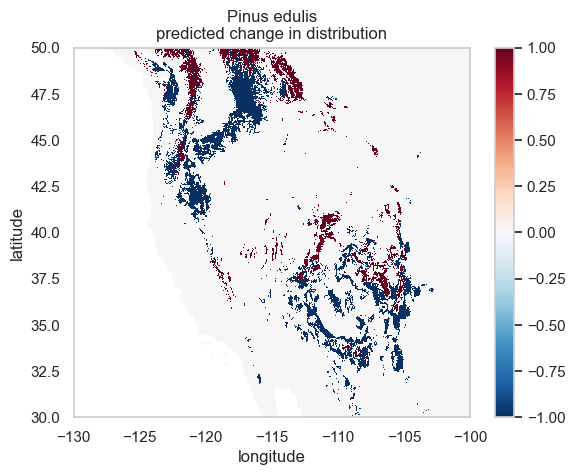

In [61]:
change_pa = future_pa.astype('int') - curr_pa.astype('int')
change_pa.where(mask_array == 1).plot()
plt.title("Pinus edulis\npredicted change in distribution")
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.show()

## Exercise

In a previous lab, you used data from the *Sonar.csv* file to model types of object (rocks 'R' or mines 'M') using the values of a set of frequency bands. The exercise for this lab is to use one of the ensemble methods (random forest *or* boosted regression trees) to produce a new model of these data. You should use the **scikit-learn** framework to set up and test your model, and you need to do the following:

- Run the model with the default hyperparameter settings, and report the AUC for the test set [1]
- Use `GridSearchCV()` to tune the model [2]
- Report the AUC score for the tuned model, as well as the tuned parameters [1]
- Produce a variable importance plot [1]

In addition, your answer should include your code, either as a word document or jupyter notebook

## Appendix 1: Bioclimate variables

- BIO1 = Annual Mean Temperature
- BIO2 = Mean Diurnal Range (Mean of monthly (max temp - min temp))
- BIO3 = Isothermality (BIO2/BIO7) (* 100)
- BIO4 = Temperature Seasonality (standard deviation *100)
- BIO5 = Max Temperature of Warmest Month
- BIO6 = Min Temperature of Coldest Month
- BIO7 = Temperature Annual Range (BIO5-BIO6)
- BIO8 = Mean Temperature of Wettest Quarter
- BIO9 = Mean Temperature of Driest Quarter
- BIO10 = Mean Temperature of Warmest Quarter
- BIO11 = Mean Temperature of Coldest Quarter
- BIO12 = Annual Precipitation
- BIO13 = Precipitation of Wettest Month
- BIO14 = Precipitation of Driest Month
- BIO15 = Precipitation Seasonality (Coefficient of Variation)
- BIO16 = Precipitation of Wettest Quarter
- BIO17 = Precipitation of Driest Quarter
- BIO18 = Precipitation of Warmest Quarter
- BIO19 = Precipitation of Coldest Quarter